#  1. ИМПОРТИРУЕМ НУЖНЫЕ БИБЛИОТЕКИ

In [21]:
import warnings
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN


sns.set(rc={'figure.figsize':(10, 8)})

#    2. ИМПОРТИРУЕМ ТАБЛИЦЫ и совмещаем их с помощью left_join

In [2]:
df1 = pd.read_csv('identity_small.csv', sep =',')
df2 = pd.read_csv('trans_small.csv', sep =',')
df = df2.set_index('TransactionID').join(df1.set_index('TransactionID'))
df

,D4,card1,card2,card3,addr1,addr2,TransactionAmt,isFraud,C13,D10,...,V73,V147,M5,id_04,id_20,id_24,id_33,id_29,id_22,id_02
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,NaN,13926,NaN,150.0,315.0,87.0,68.50,0,1.0,13.0,...,0.0,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0.0,2755,404.0,150.0,325.0,87.0,29.00,0,1.0,0.0,...,0.0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0.0,4663,490.0,150.0,330.0,87.0,59.00,0,1.0,0.0,...,0.0,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,94.0,18132,567.0,150.0,476.0,87.0,50.00,0,25.0,84.0,...,0.0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,NaN,4497,514.0,150.0,420.0,87.0,50.00,0,1.0,NaN,...,NaN,0.0,NaN,NaN,144.0,NaN,2220x1080,NotFound,NaN,70787.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,NaN,6550,NaN,150.0,272.0,87.0,49.00,0,3.0,56.0,...,0.0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,0.0,10444,225.0,150.0,204.0,87.0,39.50,0,1.0,0.0,...,0.0,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537,0.0,12037,595.0,150.0,231.0,87.0,30.95,0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#    3. УДАЛЯЕМ Target

In [7]:
target = df.isFraud
df = df.drop(columns = ['isFraud'])

#    4. АНАЛИЗИРУЕМ

Для начала посмотрим общую информацию о датасете.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
D4,421618.0,140.002441,191.096774,-122.000,0.000,26.000,253.0,869.000
card1,590540.0,9898.734658,4901.170153,1000.000,6019.000,9678.000,14184.0,18396.000
card2,581607.0,362.555488,157.793246,100.000,214.000,361.000,512.0,600.000
card3,588975.0,153.194925,11.336444,100.000,150.000,150.000,150.0,231.000
addr1,524834.0,290.733794,101.741072,100.000,204.000,299.000,330.0,540.000
addr2,524834.0,86.800630,2.690623,10.000,87.000,87.000,87.0,102.000
TransactionAmt,590540.0,135.027176,239.162522,0.251,43.321,68.769,125.0,31937.391
C13,590540.0,32.539918,129.364844,0.000,1.000,3.000,12.0,2918.000
D10,514518.0,123.982137,182.615225,0.000,0.000,15.000,197.0,876.000
D1,589271.0,94.347568,157.660387,0.000,0.000,3.000,122.0,640.000


Имеем большой разброс в колонках TransactionAmt, C13, D1, D4.1, id_02 и т.д
А также очень много пропущенных значений. Посмотрим сситуацию с NaN. Проанализируем ситуацию с NaN

In [6]:
s = df.isna().sum()
nan = pd.DataFrame(data = s[s != 0].sort_values(ascending=False), columns=['Total NaN count'])
nan['Percent'] = df.isna().mean() * 100.0

nan.T

,id_24,id_22,id_04,id_33,V147,V274,V225,V277,V243,V244,...,V40,D4.1,D4,V73,D10,addr2,addr1,card2,card3,D1
Total NaN count,585793.000000,585371.000000,524216.000000,517251.000000,508595.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,...,168969.000000,168922.000000,168922.000000,77096.00000,76022.000000,65706.000000,65706.000000,8933.000000,1565.000000,1269.000000
Percent,99.196159,99.124699,88.768923,87.589494,86.123717,77.913435,77.913435,77.913435,77.913435,77.913435,...,28.612626,28.604667,28.604667,13.05517,12.873302,11.126427,11.126427,1.512683,0.265012,0.214888


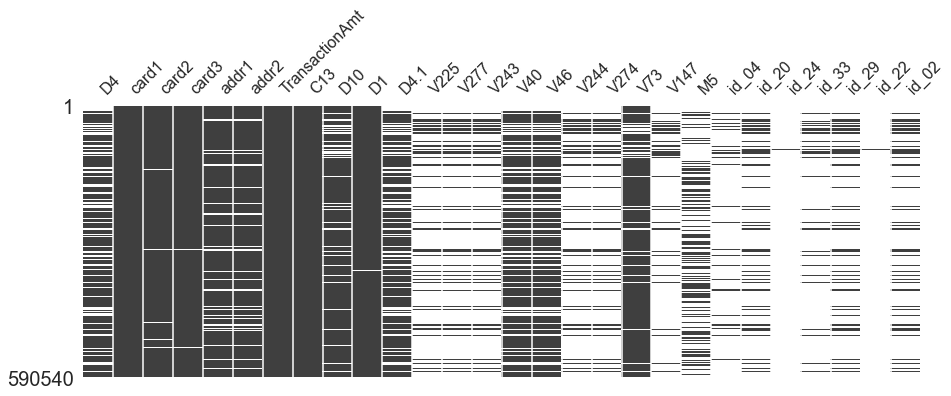

In [7]:
figure, ax = plt.subplots( figsize=(15, 5))
msno.matrix(df, ax=ax, sparkline=False)
plt.show()

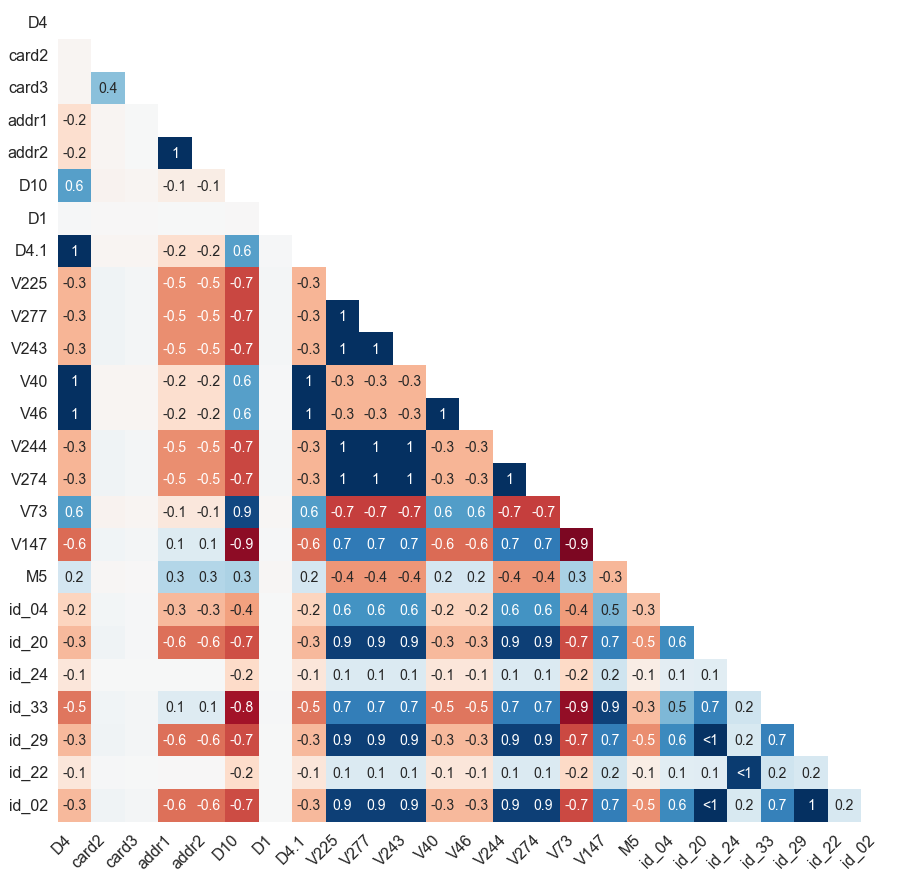

In [8]:
msno.heatmap(df, figsize=(15, 15), cbar=False)
plt.show()

<AxesSubplot:>

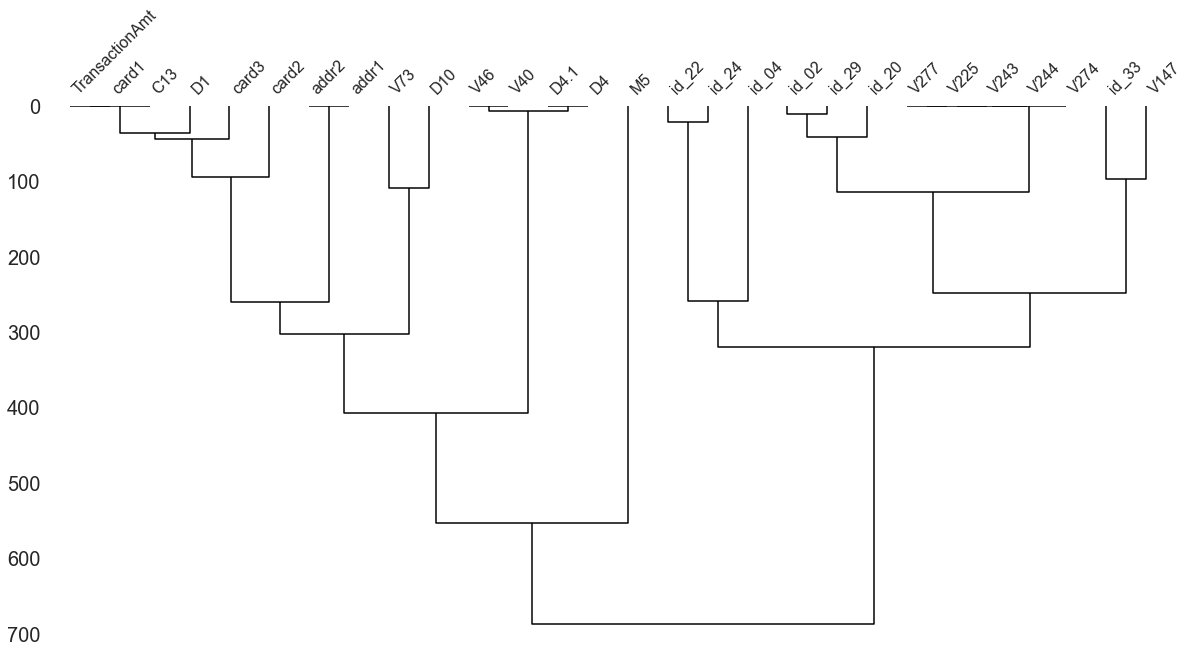

In [9]:
msno.dendrogram(df, figsize=(20, 10))

Как видим ситуация с NaN пугает... Много пропущеных значений и при этом имеющие связи друг с другом
Для решения ситуации с NaN воспользуемся специальной библиотекой missingpy. Что для каждого признака дает разные, найподходящие значения.
Но для этого, поменяем все строковые типы данных в float.
В самой замене, будем использовать MissForest так как при KNN надо чтобы было менее 80% информации NaN но такой вариант меня не устраивает, так как пришлось бы удалять признаки, что очень не желательно. Для рандомного леса выбиру количество деревьев в 40. Для этого датасета вполне достаточно такого количества. Больше не надо, чтобы не ждать несколько дней.

In [10]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cols_obj = list(set(cols) - set(num_cols))

for i in cols_obj:
    df[i] = LabelEncoder().fit_transform(df[i].tolist())

In [11]:
# from missingpy import MissForest
#
# imputer = MissForest(random_state=42, n_estimators = 40,  oob_score = True, n_jobs= -1)
# df_ForestImputer = imputer.fit_transform(df)

Это было достаточно долго. Поэтому, чтобы не пришлось ждать еще раз сохраним наш новый датасет Заккоментирую код, чтобы не запустить это еще раз

In [12]:
# df_ForestImputer = pd.DataFrame(df_ForestImputer, columns = df.columns)
# df_ForestImputer.to_csv('ForestImputer.csv', index=False)

In [4]:
df_ForestImputer = pd.read_csv('ForestImputer.csv')
colums = df_ForestImputer.columns
df_ForestImputer

,D4,card1,card2,card3,addr1,addr2,TransactionAmt,C13,D10,D1,...,V73,V147,M5,id_04,id_20,id_24,id_33,id_29,id_22,id_02
0,140.0,13926.0,396.225,150.0,315.0,87.0,68.50,1.0,13.0,14.0,...,0.0,0.350,0.0,0.000,279.500,12.025,260.0,2.0,14.0,302449.450
1,0.0,2755.0,404.000,150.0,325.0,87.0,29.00,1.0,0.0,0.0,...,0.0,0.000,1.0,0.000,383.250,13.200,260.0,2.0,14.0,160822.650
2,0.0,4663.0,490.000,150.0,330.0,87.0,59.00,1.0,0.0,0.0,...,0.0,0.000,0.0,0.000,302.475,13.500,260.0,2.0,14.0,147619.150
3,94.0,18132.0,567.000,150.0,476.0,87.0,50.00,25.0,84.0,112.0,...,0.0,0.175,1.0,0.000,246.200,12.300,260.0,2.0,14.0,270130.625
4,140.0,4497.0,514.000,150.0,420.0,87.0,50.00,1.0,0.0,0.0,...,0.0,0.000,2.0,0.000,144.000,11.000,164.0,1.0,14.0,70787.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,140.0,6550.0,577.200,150.0,272.0,87.0,49.00,3.0,56.0,29.0,...,0.0,0.000,1.0,0.000,542.625,12.000,260.0,2.0,14.0,149232.750
590536,0.0,10444.0,225.000,150.0,204.0,87.0,39.50,1.0,0.0,0.0,...,0.0,0.000,0.0,0.000,506.975,13.400,260.0,2.0,14.0,213129.600
590537,0.0,12037.0,595.000,150.0,231.0,87.0,30.95,1.0,0.0,0.0,...,0.0,0.000,2.0,0.000,435.150,13.300,260.0,2.0,14.0,148818.875
590538,22.0,7826.0,481.000,150.0,387.0,87.0,117.00,5.0,22.0,22.0,...,0.0,0.150,0.0,-0.025,358.425,12.100,260.0,2.0,14.5,421780.925


Теперь когда все готово можно воспользоватся K-Means

#    5. K-MEANS

Для начала применим MinMaxScaler, чтобы небыло никаких проблем с разбросом

In [11]:
df_ForestImputer = MinMaxScaler().fit_transform(df_ForestImputer)
df_ForestImputer

array([[0.26437941, 0.74304438, 0.59245   , ..., 1.        , 0.11764706,
        0.30257129],
       [0.12310797, 0.10088526, 0.608     , ..., 1.        , 0.11764706,
        0.16088697],
       [0.12310797, 0.21056565, 0.78      , ..., 1.        , 0.11764706,
        0.14767811],
       ...,
       [0.12310797, 0.6344562 , 0.99      , ..., 1.        , 0.11764706,
        0.14887832],
       [0.14530777, 0.39238905, 0.762     , ..., 1.        , 0.13235294,
        0.42195124],
       [0.12411705, 0.80857668, 0.14      , ..., 1.        , 0.11764706,
        0.34229702]])

Далее применяем KMeans и ищем 2 кластера, сравниваем полученый результат с оригиналом

In [15]:
km = KMeans(n_clusters = 2, random_state= 42)

km_clustering = km.fit_predict(df_ForestImputer)

In [16]:
score = silhouette_score(df_ForestImputer, km_clustering, sample_size=30000)

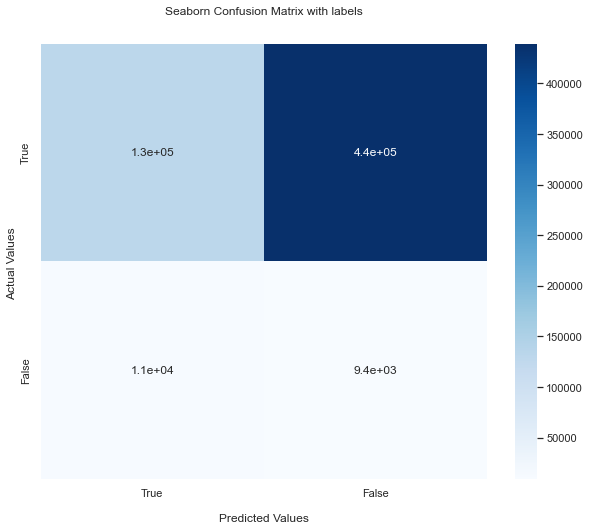

[[130726 439151]
 [ 11292   9371]]
Score 0.2665253800712194
accuracy 0.2372354116571274


In [17]:
cm = confusion_matrix(target, km_clustering)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(cm)
print("Score", score)
print ("accuracy", (cm[0][0] + cm[1][1]) / cm.sum())

Что же. Для несбалансированого класса результат разочаровует. Очень много ложных положительных значений создают кластеры

Найдем оптимальное количество кластеров

In [18]:
range_n_clusters = np.arange(2, 6)
scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state= 42)
    preds = clusterer.fit_predict(df_ForestImputer)

    score = silhouette_score(df_ForestImputer, preds, sample_size=30000)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    scores.append(score)

For n_clusters = 2, silhouette score is 0.2653616544944464)
For n_clusters = 3, silhouette score is 0.21232761011752815)
For n_clusters = 4, silhouette score is 0.19060165223670056)
For n_clusters = 5, silhouette score is 0.21251377287446424)


Оптимальное количество кластреов - 2. Что меня устраивает. Так как в самой задаче их также было 2

Нарисуем график

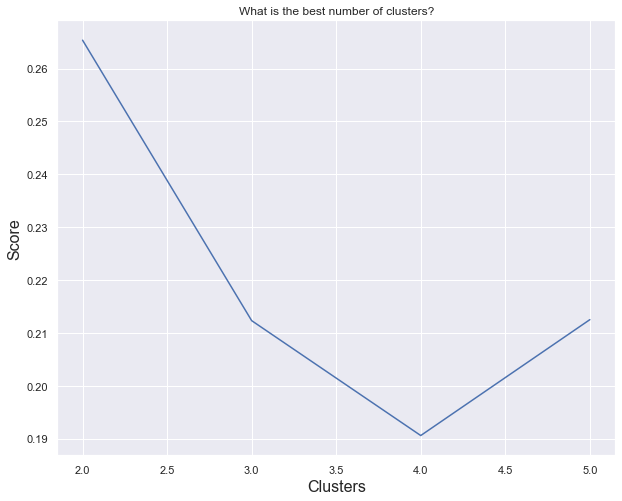

In [19]:
plt.plot(range_n_clusters, scores)
plt.xlabel("Clusters", fontsize = 16)
plt.ylabel("Score", fontsize = 16)
plt.title("What is the best number of clusters?")
plt.show();

Отлично, мы определились, что оптимальное количество кластеров - 2. Нарисуем эти кластера. Для этого применим сокращение числености PCA

In [20]:
pca = PCA(n_components=3).fit_transform(df_ForestImputer)

In [21]:
pca_df = pd.DataFrame(pca, columns = ['1', '2', '3'])
pca_df

,1,2,3
0,-0.604790,-0.399351,0.095408
1,-0.197877,-0.261690,0.015374
2,-0.550489,-0.546626,0.233096
3,-0.226334,-0.107053,0.413608
4,0.499192,-0.090131,0.244077
...,...,...,...
590535,-0.162673,-0.189076,0.394866
590536,-0.572888,-0.490511,-0.277290
590537,0.190183,-0.033735,0.326900
590538,-0.561312,-0.493330,0.239249


In [22]:
pca_df['target'] = km_clustering

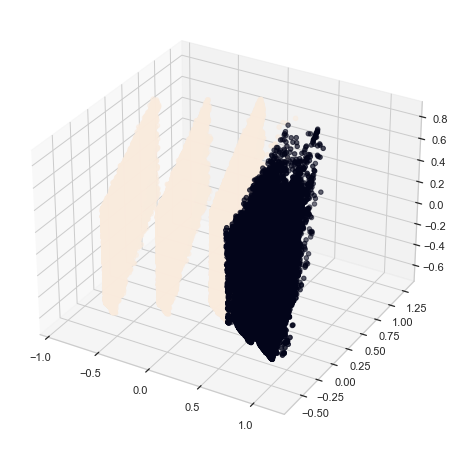

In [23]:
sns.set_style("whitegrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = pca_df['1']
y = pca_df['2']
z = pca_df['3']
color = pca_df['target']

ax.scatter(xs = x, ys = y, zs = z, c = color)

plt.show()

Попробуем найти гипперпараметры для K_means. Подберу не лучшие а хорошие гиперпараметры так как GridSearch будет искать очень долго

In [32]:
iters = np.arange(200, 450, 50)
scores = []

for iter in iters:
    clusterer = KMeans(n_clusters=2, random_state= 42, max_iter= iter)
    preds = clusterer.fit_predict(df_ForestImputer)

    score = silhouette_score(df_ForestImputer, preds, sample_size=30000)
    print("For max_iter = {}, silhouette score is {})".format(iter, score))
    scores.append(score)

For max_iter = 200, silhouette score is 0.26705137616448305)
For max_iter = 250, silhouette score is 0.2670423669643286)
For max_iter = 300, silhouette score is 0.26488687468255917)
For max_iter = 350, silhouette score is 0.26623926489932587)
For max_iter = 400, silhouette score is 0.2653955767042105)


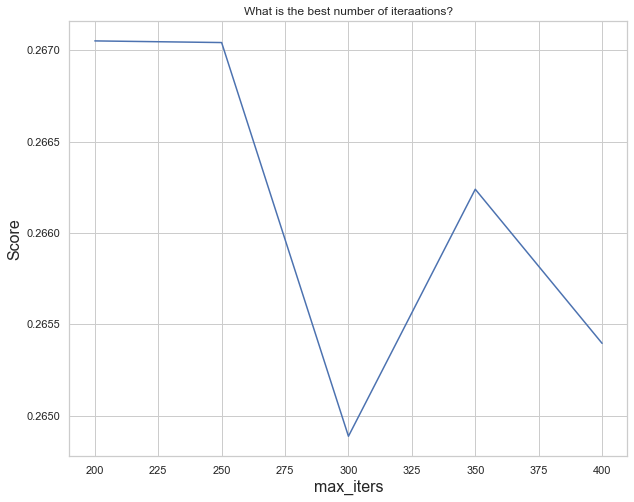

In [33]:
plt.plot(iters, scores)
plt.xlabel("max_iters", fontsize = 16)
plt.ylabel("Score", fontsize = 16)
plt.title("What is the best number of iteraations?")
plt.show();

In [35]:
inits = np.arange(5,21)
scores = []

for init in inits:
    clusterer = KMeans(n_clusters=2, random_state= 42, max_iter= 200, n_init = init)
    preds = clusterer.fit_predict(df_ForestImputer)

    score = silhouette_score(df_ForestImputer, preds, sample_size=30000)
    print("For n_init = {}, silhouette score is {})".format(init, score))
    scores.append(score)

For n_init = 5, silhouette score is 0.26575924169513193)
For n_init = 6, silhouette score is 0.266580471689736)
For n_init = 7, silhouette score is 0.2650246814621171)
For n_init = 8, silhouette score is 0.26660141052626257)
For n_init = 9, silhouette score is 0.26537086169879487)
For n_init = 10, silhouette score is 0.2675061164757162)
For n_init = 11, silhouette score is 0.2674748309077856)
For n_init = 12, silhouette score is 0.26543189587461624)
For n_init = 13, silhouette score is 0.2673465265529872)
For n_init = 14, silhouette score is 0.26548589189946825)
For n_init = 15, silhouette score is 0.2659352175351197)
For n_init = 16, silhouette score is 0.2666156458582104)
For n_init = 17, silhouette score is 0.26681147373220665)
For n_init = 18, silhouette score is 0.2654767939601196)
For n_init = 19, silhouette score is 0.2670829229717836)
For n_init = 20, silhouette score is 0.26525554442906496)


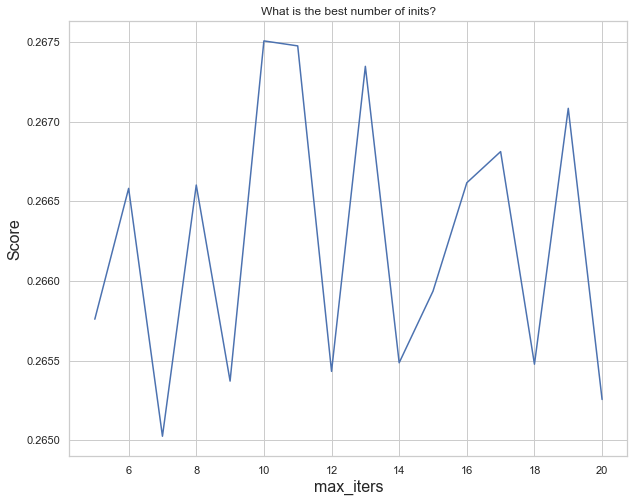

In [36]:
plt.plot(inits, scores)
plt.xlabel("max_iters", fontsize = 16)
plt.ylabel("Score", fontsize = 16)
plt.title("What is the best number of inits?")
plt.show();

Добавляю результаты в таблицу и делаем вид, что этот target у нас был изначально (то есть получаем обычную задачу Supervised).

In [42]:
clusterer = KMeans(n_clusters=2, random_state= 42, max_iter= 200, n_init = 10)
preds = clusterer.fit_predict(df_ForestImputer)
clusterer = pd.DataFrame(data= preds, columns=['isFraud'])
clusterer

,isFraud
0,0
1,1
2,1
3,0
4,1
...,...
590535,1
590536,1
590537,1
590538,0


In [43]:
df_ForestImputer = pd.DataFrame(data=df_ForestImputer, columns= colums)
df_ForestImputer

,D4,card1,card2,card3,addr1,addr2,TransactionAmt,C13,D10,D1,...,V73,V147,M5,id_04,id_20,id_24,id_33,id_29,id_22,id_02
0,140.0,13926.0,396.225,150.0,315.0,87.0,68.50,1.0,13.0,14.0,...,0.0,0.350,0.0,0.000,279.500,12.025,260.0,2.0,14.0,302449.450
1,0.0,2755.0,404.000,150.0,325.0,87.0,29.00,1.0,0.0,0.0,...,0.0,0.000,1.0,0.000,383.250,13.200,260.0,2.0,14.0,160822.650
2,0.0,4663.0,490.000,150.0,330.0,87.0,59.00,1.0,0.0,0.0,...,0.0,0.000,0.0,0.000,302.475,13.500,260.0,2.0,14.0,147619.150
3,94.0,18132.0,567.000,150.0,476.0,87.0,50.00,25.0,84.0,112.0,...,0.0,0.175,1.0,0.000,246.200,12.300,260.0,2.0,14.0,270130.625
4,140.0,4497.0,514.000,150.0,420.0,87.0,50.00,1.0,0.0,0.0,...,0.0,0.000,2.0,0.000,144.000,11.000,164.0,1.0,14.0,70787.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,140.0,6550.0,577.200,150.0,272.0,87.0,49.00,3.0,56.0,29.0,...,0.0,0.000,1.0,0.000,542.625,12.000,260.0,2.0,14.0,149232.750
590536,0.0,10444.0,225.000,150.0,204.0,87.0,39.50,1.0,0.0,0.0,...,0.0,0.000,0.0,0.000,506.975,13.400,260.0,2.0,14.0,213129.600
590537,0.0,12037.0,595.000,150.0,231.0,87.0,30.95,1.0,0.0,0.0,...,0.0,0.000,2.0,0.000,435.150,13.300,260.0,2.0,14.0,148818.875
590538,22.0,7826.0,481.000,150.0,387.0,87.0,117.00,5.0,22.0,22.0,...,0.0,0.150,0.0,-0.025,358.425,12.100,260.0,2.0,14.5,421780.925


In [44]:
clustered_df = df_ForestImputer.join(clusterer[['isFraud']])

In [45]:
clustered_df

,D4,card1,card2,card3,addr1,addr2,TransactionAmt,C13,D10,D1,...,V147,M5,id_04,id_20,id_24,id_33,id_29,id_22,id_02,isFraud
0,140.0,13926.0,396.225,150.0,315.0,87.0,68.50,1.0,13.0,14.0,...,0.350,0.0,0.000,279.500,12.025,260.0,2.0,14.0,302449.450,0
1,0.0,2755.0,404.000,150.0,325.0,87.0,29.00,1.0,0.0,0.0,...,0.000,1.0,0.000,383.250,13.200,260.0,2.0,14.0,160822.650,1
2,0.0,4663.0,490.000,150.0,330.0,87.0,59.00,1.0,0.0,0.0,...,0.000,0.0,0.000,302.475,13.500,260.0,2.0,14.0,147619.150,1
3,94.0,18132.0,567.000,150.0,476.0,87.0,50.00,25.0,84.0,112.0,...,0.175,1.0,0.000,246.200,12.300,260.0,2.0,14.0,270130.625,0
4,140.0,4497.0,514.000,150.0,420.0,87.0,50.00,1.0,0.0,0.0,...,0.000,2.0,0.000,144.000,11.000,164.0,1.0,14.0,70787.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,140.0,6550.0,577.200,150.0,272.0,87.0,49.00,3.0,56.0,29.0,...,0.000,1.0,0.000,542.625,12.000,260.0,2.0,14.0,149232.750,1
590536,0.0,10444.0,225.000,150.0,204.0,87.0,39.50,1.0,0.0,0.0,...,0.000,0.0,0.000,506.975,13.400,260.0,2.0,14.0,213129.600,1
590537,0.0,12037.0,595.000,150.0,231.0,87.0,30.95,1.0,0.0,0.0,...,0.000,2.0,0.000,435.150,13.300,260.0,2.0,14.0,148818.875,1
590538,22.0,7826.0,481.000,150.0,387.0,87.0,117.00,5.0,22.0,22.0,...,0.150,0.0,-0.025,358.425,12.100,260.0,2.0,14.5,421780.925,0


Давайте сравним баланс классов сейчас... Это можно было сделать и раньше, но решил это сделать с "Полным" датасетом

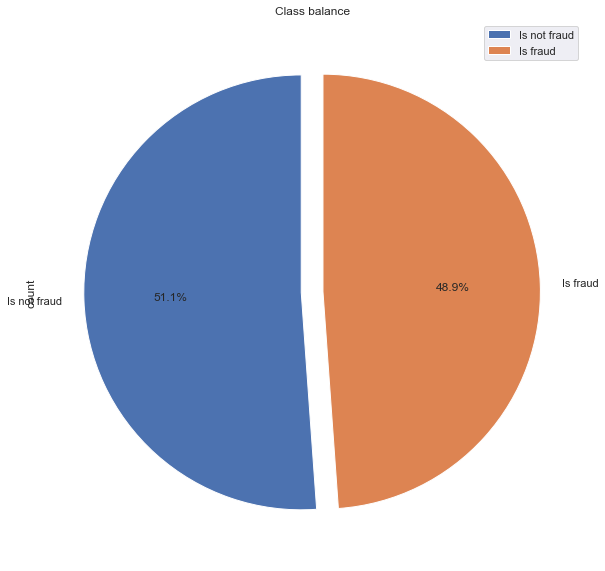

In [47]:
figure, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Class balance")

pd.DataFrame(
    {'count': [clustered_df['isFraud'].isin([0]).sum(),
               clustered_df['isFraud'].isin([1]).sum()]},
    index=['Is not fraud','Is fraud']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05), ax=ax)

plt.show()

Баланс классов просто отличный. особенно если сравнивать с оригиналом... Поэтому и обучение будет показывать лучше результат

#    6. DBSCAN

In [10]:
clustering = DBSCAN(n_jobs=-1).fit_predict(df_ForestImputer)

In [13]:
print("DBSCAN generated {} clusters.".format(len(np.unique(clustering))))

DBSCAN generated 1064 clusters.


Количество кластеров просто огромное... Гипперпараметры могли бы повлиять на результат. Но эксперементировать в рамках ознакомления с DBSCAN, учитывая сколько ресурсов и времени нужно. Желания нет. Тут даже не имеет смысла сравнивать с оригиналом, как я это делал в KMeans

In [14]:
clusterer_DBSCAN = pd.DataFrame(data= clustering, columns=['isFraud'])
clusterer_DBSCAN

,isFraud
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
590535,-1
590536,-1
590537,-1
590538,-1


#  7. Сравниваем

In [18]:
X = clustered_df.drop(columns=["isFraud"])
y = clustered_df["isFraud"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Сравним с помощью XGBoost так как именно эту модель использовали в работе номер 10

In [31]:
xgb = XGBClassifier(use_rmm= True).fit(X_train, y_train)
pred = xgb.predict(X_test)
roc_auc_score(y_test, pred)

[01:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.999991313864809

In [32]:
clustered_df.drop(columns=["isFraud"])
clustered_df = df_ForestImputer.join(clusterer_DBSCAN[['isFraud']])
clustered_df

,D4,card1,card2,card3,addr1,addr2,TransactionAmt,C13,D10,D1,...,V147,M5,id_04,id_20,id_24,id_33,id_29,id_22,id_02,isFraud
0,140.0,13926.0,396.225,150.0,315.0,87.0,68.50,1.0,13.0,14.0,...,0.350,0.0,0.000,279.500,12.025,260.0,2.0,14.0,302449.450,-1
1,0.0,2755.0,404.000,150.0,325.0,87.0,29.00,1.0,0.0,0.0,...,0.000,1.0,0.000,383.250,13.200,260.0,2.0,14.0,160822.650,-1
2,0.0,4663.0,490.000,150.0,330.0,87.0,59.00,1.0,0.0,0.0,...,0.000,0.0,0.000,302.475,13.500,260.0,2.0,14.0,147619.150,-1
3,94.0,18132.0,567.000,150.0,476.0,87.0,50.00,25.0,84.0,112.0,...,0.175,1.0,0.000,246.200,12.300,260.0,2.0,14.0,270130.625,-1
4,140.0,4497.0,514.000,150.0,420.0,87.0,50.00,1.0,0.0,0.0,...,0.000,2.0,0.000,144.000,11.000,164.0,1.0,14.0,70787.000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,140.0,6550.0,577.200,150.0,272.0,87.0,49.00,3.0,56.0,29.0,...,0.000,1.0,0.000,542.625,12.000,260.0,2.0,14.0,149232.750,-1
590536,0.0,10444.0,225.000,150.0,204.0,87.0,39.50,1.0,0.0,0.0,...,0.000,0.0,0.000,506.975,13.400,260.0,2.0,14.0,213129.600,-1
590537,0.0,12037.0,595.000,150.0,231.0,87.0,30.95,1.0,0.0,0.0,...,0.000,2.0,0.000,435.150,13.300,260.0,2.0,14.0,148818.875,-1
590538,22.0,7826.0,481.000,150.0,387.0,87.0,117.00,5.0,22.0,22.0,...,0.150,0.0,-0.025,358.425,12.100,260.0,2.0,14.5,421780.925,-1


In [33]:
X = clustered_df.drop(columns=["isFraud"])
y = clustered_df["isFraud"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
xgb = XGBClassifier(use_rmm= True).fit(X_train, y_train)

[11:18:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Результат получше того что у нас в работе номер 10... Оно и логично, учитывая, что компьютер сам нашел "isFraud" и теперь еще написал логику для дальнейшего предсказания

In [40]:
roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class="ovo")

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [41]:
roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class="ovr")

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

Сравнить DBSCAN не удалось. Если верить StackOverFlow то проблема лежит в том, что когда я делал разделение на тест и тренировку, то у меня не все возможные значения y оказались в переменной y_test. Поэтому и видно вот такую ошибку. Можно постраться исправить ситуацию, но учитывая как долго XGboost работает с кластерами от DBSCAN это будет долгим занятием...

#  Выводы